In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import catboost as cat
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from category_encoders import TargetEncoder 
# from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("../../datasets/insurance_dataset/insurance.csv")
target = "charges"

num_features = list(df.select_dtypes(exclude='object'))
num_features.remove(target)
cat_features = list(df.select_dtypes(include='object'))
catboost_features = num_features+cat_features

In [4]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

# Dataset preprocessing

In [5]:
df.loc[:, num_features] = df.loc[:, num_features].fillna(0)
df.loc[:, cat_features] = df.loc[:, cat_features].fillna('Other')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df[num_features+cat_features], 
    df[[target]], 
    test_size=0.33, random_state=2025)

# 3. Кодирование категориальных признаков
encoder = TargetEncoder(cols=cat_features)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

scaler = MinMaxScaler()
scaled_X_train_encoded = scaler.fit_transform(X_train_encoded)
scaled_X_train_encoded = pd.DataFrame(scaled_X_train_encoded , columns=catboost_features)
df_train = pd.concat([scaled_X_train_encoded.reset_index(drop=True), 
                      y_train.reset_index(drop=True)], axis=1)

scaled_X_test_encoded = scaler.transform(X_test_encoded[catboost_features])
scaled_X_test_encoded = pd.DataFrame(scaled_X_test_encoded , columns=catboost_features)
df_test = pd.concat([scaled_X_test_encoded.reset_index(drop=True), 
                     y_test.reset_index(drop=True)], axis=1)

In [9]:
linear_features = catboost_features

In [10]:
scaler = MinMaxScaler()
scaled_df_train = scaler.fit_transform(df_train[linear_features])
scaled_df_train = pd.DataFrame(scaled_df_train, columns=linear_features)
scaled_df_train = pd.concat([scaled_df_train, df_train[[target]]], axis=1)

scaled_df_test = scaler.transform(df_test[linear_features])
scaled_df_test = pd.DataFrame(scaled_df_test, columns=linear_features)
scaled_df_test = pd.concat([scaled_df_test, df_test[[target]]], axis=1)

# Simple Linear Regression

In [11]:
result_metrics = pd.DataFrame(columns=[
     'algorithm',
     'dataset_type',
     'R2',
     'MSE',
     'RMSE',
     'MAE',
     'MAPE'
])

In [12]:
def get_metrics(y_true, y_pred, algorithm, dataset_type, res_df=None):
    res_df = res_df.copy()
    
    r2 = metrics.r2_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

    print(f"{algorithm}, -- Type Dataset - {dataset_type}")
    print(f"R2 = {r2}")
    print(f"MSE = {mse}")
    print(f"RMSE = {mse**0.5}")
    print(f"MAE = {mae}")
    print(f"MAPE = {mape}")
    
    curr_res = [algorithm, dataset_type] + [r2, mse, mse**0.5, mae, mape]
    res_df = pd.concat([res_df,
                        pd.DataFrame([curr_res], columns=['algorithm',
                                                            'dataset_type',
                                                            'R2',
                                                            'MSE',
                                                            'RMSE',
                                                            'MAE',
                                                            'MAPE'])])
    return res_df

In [13]:
simple_model = LinearRegression()
simple_model.fit(scaled_df_train[linear_features], scaled_df_train[target])

LinearRegression()

In [14]:
preds_train = simple_model.predict(scaled_df_train[linear_features])
preds_test = simple_model.predict(scaled_df_test[linear_features])

In [15]:
result_metrics = get_metrics(scaled_df_train[target], preds_train, 
                              algorithm='simple_regression', dataset_type='train', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - train
R2 = 0.7593755691031159
MSE = 34853716.01600166
RMSE = 5903.703584700172
MAE = 4046.188582614292
MAPE = 0.3979386697850503


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_10613/2903524573.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df,


In [16]:
result_metrics = get_metrics(scaled_df_test[target], preds_test, 
                              algorithm='simple_regression', dataset_type='test', 
                              res_df=result_metrics)

simple_regression, -- Type Dataset - test
R2 = 0.7300822087293477
MSE = 40400572.9751795
RMSE = 6356.144505530023
MAE = 4362.732313749529
MAPE = 0.41156728286886124


In [17]:
result_metrics

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.759376,3.485372e+07,5903.703585,4046.188583,0.397939
0,simple_regression,test,0.730082,4.040057e+07,6356.144506,4362.732314,0.411567


# Combine with classifier after k-means

## fit k-means 2 clusters on target

### clustering

In [18]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[[target]])
clf_target ='kmeans'

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

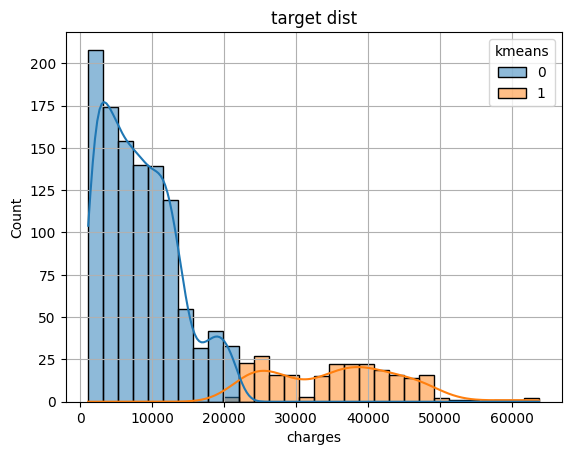

In [19]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [20]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [21]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       736
           1       1.00      0.84      0.91       160

    accuracy                           0.97       896
   macro avg       0.98      0.92      0.95       896
weighted avg       0.97      0.97      0.97       896



In [22]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       360
           1       0.97      0.76      0.85        82

    accuracy                           0.95       442
   macro avg       0.96      0.88      0.91       442
weighted avg       0.95      0.95      0.95       442



### fit regression

In [23]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [24]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (736, 8) (160, 8)
test (378, 9) (64, 9)


In [25]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [26]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2_regression, -- Type Dataset - train
R2 = 0.927425012084914
MSE = 10512265.979098108
RMSE = 3242.262478439725
MAE = 1716.2608142413867
MAPE = 0.16170030521393894
segm_kmeans2_regression, -- Type Dataset - test
R2 = 0.8362767736495849
MSE = 24505654.565279335
RMSE = 4950.318632702277
MAE = 2430.668465861961
MAPE = 0.18164862074080995


## fit k-means 3  clusters on target

### clustering

In [27]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[[target]])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[[target]])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[[target]])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

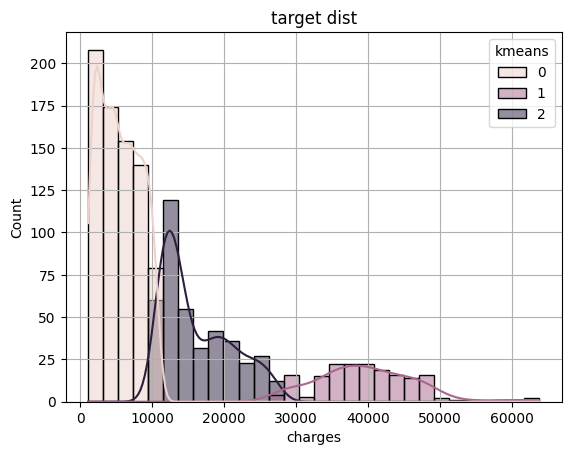

In [28]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [29]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [30]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       517
           1       1.00      1.00      1.00       119
           2       1.00      0.99      1.00       260

    accuracy                           1.00       896
   macro avg       1.00      1.00      1.00       896
weighted avg       1.00      1.00      1.00       896



In [31]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       238
           1       0.95      0.90      0.92        58
           2       0.90      0.77      0.83       146

    accuracy                           0.89       442
   macro avg       0.91      0.88      0.89       442
weighted avg       0.89      0.89      0.89       442



### fit regression

In [32]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [33]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (517, 8) (119, 8) (260, 8)
test (261, 9) (55, 9) (126, 9)


In [34]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [35]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3_regression', dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3_regression, -- Type Dataset - train
R2 = 0.9487550437892068
MSE = 7422675.845366763
RMSE = 2724.458816970219
MAE = 1411.1623658129508
MAPE = 0.10851412481911729
segm_kmeans3_regression, -- Type Dataset - test
R2 = 0.8322594857113568
MSE = 25106951.477745365
RMSE = 5010.683733558262
MAE = 2449.860534294695
MAPE = 0.15792363196760908


## fit 2 clusters on features

### clustering

In [36]:
kmeans = KMeans(n_clusters=2, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

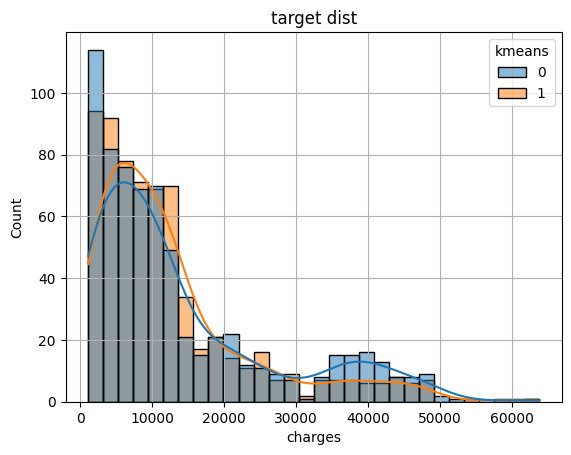

In [37]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [38]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [39]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       452

    accuracy                           1.00       896
   macro avg       1.00      1.00      1.00       896
weighted avg       1.00      1.00      1.00       896



In [40]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       232
           1       1.00      1.00      1.00       210

    accuracy                           1.00       442
   macro avg       1.00      1.00      1.00       442
weighted avg       1.00      1.00      1.00       442



### fit regression

In [41]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]

In [42]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape)

train (444, 8) (452, 8)
test (232, 9) (210, 9)


In [43]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

In [44]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target]]),
                             np.hstack([pred_train_0, pred_train_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target]]),
                             np.hstack([pred_test_0, pred_test_1]),
                              algorithm='segm_kmeans2onFeatures_regression', 
                              dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans2onFeatures_regression, -- Type Dataset - train
R2 = 0.7611047439229053
MSE = 34603250.30939687
RMSE = 5882.452746040283
MAE = 4020.289872466939
MAPE = 0.3955556680520586
segm_kmeans2onFeatures_regression, -- Type Dataset - test
R2 = 0.7305066537571208
MSE = 40337043.17880048
RMSE = 6351.145028953479
MAE = 4341.408813597989
MAPE = 0.41046931724013835


## fit 3 clusters on features

### clustering

In [45]:
kmeans = KMeans(n_clusters=3, random_state=2025)
kmeans.fit(scaled_df_train[linear_features])

scaled_df_train['kmeans'] = kmeans.predict(scaled_df_train[linear_features])
scaled_df_test['kmeans'] = kmeans.predict(scaled_df_test[linear_features])

kmeans_data = pd.concat([scaled_df_train, scaled_df_test])

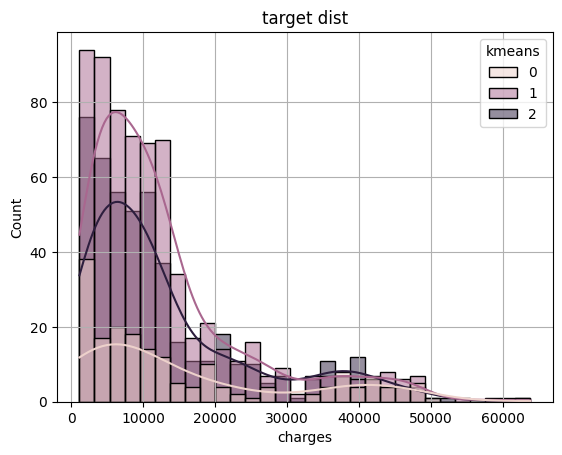

In [46]:
plt.title('target dist')
plt.grid(which='major')
sns.histplot(data = kmeans_data, x=target, kde=True, hue='kmeans')
plt.show()

### fit clf

In [47]:
clf = cat.CatBoostClassifier(random_state=2025, verbose=False)
clf.fit(scaled_df_train[catboost_features], scaled_df_train[clf_target])

clf_pred_train = clf.predict(scaled_df_train[catboost_features])
clf_pred_test = clf.predict(scaled_df_test[catboost_features])

In [48]:
print(metrics.classification_report(scaled_df_train[clf_target], clf_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       123
           1       1.00      1.00      1.00       452
           2       1.00      1.00      1.00       321

    accuracy                           1.00       896
   macro avg       1.00      1.00      1.00       896
weighted avg       1.00      1.00      1.00       896



In [49]:
print(metrics.classification_report(scaled_df_test[clf_target], clf_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00       210
           2       1.00      1.00      1.00       166

    accuracy                           1.00       442
   macro avg       1.00      1.00      1.00       442
weighted avg       1.00      1.00      1.00       442



### fit regression

In [50]:
scaled_df_train_0 = scaled_df_train[scaled_df_train[clf_target] == 0]
scaled_df_train_1 = scaled_df_train[scaled_df_train[clf_target] == 1]
scaled_df_train_2 = scaled_df_train[scaled_df_train[clf_target] == 2]

clf_pred_test = clf.predict(scaled_df_test[catboost_features])
scaled_df_test['clf_pred'] = clf_pred_test

scaled_df_test_0 = scaled_df_test[scaled_df_test['clf_pred'] == 0]
scaled_df_test_1 = scaled_df_test[scaled_df_test['clf_pred'] == 1]
scaled_df_test_2 = scaled_df_test[scaled_df_test['clf_pred'] == 2]

In [51]:
print("train", scaled_df_train_0.shape, scaled_df_train_1.shape, scaled_df_train_2.shape)
print("test", scaled_df_test_0.shape, scaled_df_test_1.shape, scaled_df_test_2.shape)

train (123, 8) (452, 8) (321, 8)
test (66, 9) (210, 9) (166, 9)


In [52]:
lr_0 = LinearRegression()
lr_0.fit(scaled_df_train_0[linear_features], scaled_df_train_0[target])
pred_train_0 = lr_0.predict(scaled_df_train_0[linear_features])
pred_test_0 = lr_0.predict(scaled_df_test_0[linear_features])

lr_1 = LinearRegression()
lr_1.fit(scaled_df_train_1[linear_features], scaled_df_train_1[target])
pred_train_1 = lr_1.predict(scaled_df_train_1[linear_features])
pred_test_1 = lr_1.predict(scaled_df_test_1[linear_features])

lr_2 = LinearRegression()
lr_2.fit(scaled_df_train_2[linear_features], scaled_df_train_2[target])
pred_train_2 = lr_2.predict(scaled_df_train_2[linear_features])
pred_test_2 = lr_2.predict(scaled_df_test_2[linear_features])

In [53]:
result_metrics = get_metrics(pd.concat([scaled_df_train_0[target], 
                                        scaled_df_train_1[target],
                                        scaled_df_train_2[target]]),
                             np.hstack([pred_train_0, pred_train_1, pred_train_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='train', 
                              res_df=result_metrics)

result_metrics = get_metrics(pd.concat([scaled_df_test_0[target], 
                                        scaled_df_test_1[target],
                                        scaled_df_test_2[target]]),
                             np.hstack([pred_test_0, pred_test_1, pred_test_2]),
                              algorithm='segm_kmeans3onFeatures_regression',
                               dataset_type='test', 
                              res_df=result_metrics)

segm_kmeans3onFeatures_regression, -- Type Dataset - train
R2 = 0.7636539699980684
MSE = 34234002.67584134
RMSE = 5850.983052089738
MAE = 3997.393452913787
MAPE = 0.3933036326008824
segm_kmeans3onFeatures_regression, -- Type Dataset - test
R2 = 0.7346458515993745
MSE = 39717499.11800535
RMSE = 6302.182091784191
MAE = 4291.037934572649
MAPE = 0.4129110201323689


# Catboost

In [54]:
catboost_features = num_features+cat_features

In [56]:
cat_model = cat.CatBoostRegressor(random_seed = 2025, verbose=False)
cat_model.fit(df_train[catboost_features], df_train[target])

In [57]:
y_train_pred = cat_model.predict(df_train[catboost_features])
y_test_pred = cat_model.predict(df_test[catboost_features])

In [58]:
result_metrics = get_metrics(df_train[target], y_train_pred,
                              algorithm='catboost_regression', dataset_type='train', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - train
R2 = 0.9576530448190317
MSE = 6133827.494234419
RMSE = 2476.6565151902714
MAE = 1332.1079451810415
MAPE = 0.1624102364180742


In [59]:
result_metrics = get_metrics(df_test[target], y_test_pred,
                              algorithm='catboost_regression', dataset_type='test', 
                              res_df=result_metrics)

catboost_regression, -- Type Dataset - test
R2 = 0.8342112133561761
MSE = 24814822.104683284
RMSE = 4981.447792026258
MAE = 2760.243997441067
MAPE = 0.27130479823841774


In [60]:
result_metrics.query('dataset_type == "train"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,train,0.759376,3.485372e+07,5903.703585,4046.188583,0.397939
0,segm_kmeans2_regression,train,0.927425,1.051227e+07,3242.262478,1716.260814,0.161700
0,segm_kmeans3_regression,train,0.948755,7.422676e+06,2724.458817,1411.162366,0.108514
0,segm_kmeans2onFeatures_regression,train,0.761105,3.460325e+07,5882.452746,4020.289872,0.395556
0,segm_kmeans3onFeatures_regression,train,0.763654,3.423400e+07,5850.983052,3997.393453,0.393304
0,catboost_regression,train,0.957653,6.133827e+06,2476.656515,1332.107945,0.162410


In [61]:
result_metrics.query('dataset_type == "test"')

,algorithm,dataset_type,R2,MSE,RMSE,MAE,MAPE
0,simple_regression,test,0.730082,4.040057e+07,6356.144506,4362.732314,0.411567
0,segm_kmeans2_regression,test,0.836277,2.450565e+07,4950.318633,2430.668466,0.181649
0,segm_kmeans3_regression,test,0.832259,2.510695e+07,5010.683734,2449.860534,0.157924
0,segm_kmeans2onFeatures_regression,test,0.730507,4.033704e+07,6351.145029,4341.408814,0.410469
0,segm_kmeans3onFeatures_regression,test,0.734646,3.971750e+07,6302.182092,4291.037935,0.412911
0,catboost_regression,test,0.834211,2.481482e+07,4981.447792,2760.243997,0.271305
